# Business Problem
This case study is based on a Kaggle competition [Santander Customer Satisfaction ](https://www.kaggle.com/c/santander-customer-satisfaction) that was conduced in the year 2016. 

Customer satisfaction is one of the most important key performance indicators in every company today and is seen as a key element of a  company’s success.

Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander is a Spanish multinational corporation bank and financial based company which operates in Europe, North and South America, and also Asia.

In this Kaggle competition that is conducted by Santander we need to predict whether a customer is dissatisfied with their services early on. This will help them to take proactive steps to improve the customer satisfaction before the customer leaves.

We are given two files :a test.csv and train.csv which contains around 370 features which are anonymized and 1 dependent feature that is TARGET. 

Each datapoint represents a customer and the value in TARGET will be 1 if a customer is dissatisfied with the company's service and 0 if he is satisfied and also the dataset is heavily imbalanced.

# Metric Used

The metric used here is the area under the ROC (receiver operating characteristic) curve which is the area under the plot between True Positive Rate (Sensitivity or Recall) and False Positive Rate at different thresholds. 

AUC helps in determining whether a model is good at distinguishing between classes. 

Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.


In [2]:
#importing relevant libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
from scipy import stats
import itertools
import random
from sklearn.manifold import TSNE

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("The no. of datapoints in train data are %i and the no. of features in train data are %i"%(train.shape[0],train.shape[1]))
print("The no. of datapoints in test data are %i and the no. of features in test data are %i"%(test.shape[0],test.shape[1]))

The no. of datapoints in train data are 76020 and the no. of features in train data are 371
The no. of datapoints in test data are 75818 and the no. of features in test data are 370


In [4]:
train.head(2)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0


In [5]:
test.head(2)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72


In [6]:
def countplot_target(df,h=500,size=(5,5)):
    """
    It shows the frequency distribution of target variable 
    for a particular df for specific feature
    with percentage annoatations above. 
    It also prints the number of satisfactory and unsatisfactory customers.
    h : represents the additional height of the text above the bar
    size : figure size
    """
    plt.figure(figsize=size)
    ax = sns.countplot(x='TARGET',data=df)
    total = df.shape[0]
    #https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + h,
                '{:1.2f}%'.format(height*100/total),
                ha="center") 
    plt.title("Distribution of TARGET feature")
    target_1 = df[df['TARGET']==1].shape[0]
    target_0 = df[df['TARGET']==0].shape[0]
    print("The no. of customers that are unsatisfied are %i."%(target_1))
    print("The no. of customers that are satisfied are %i."%(target_0))
    print('')
    plt.show()

In [7]:
def histplot_comb(col,train=train,test=test,size=(20,5),bins=20):
    """
    Creates a histplots of train and 
    test data for feature var
    """
    var=col
    plt.subplots(1,2,figsize=size)
    #plotting train data
    plt.subplot(121)
    plt.title("Distribution of {} train data".format(var))
    plt.ylabel('No. of Occurences')
    plt.xlabel(var)
    plt.hist(train[var],bins=bins)
    #plotting test data
    plt.subplot(122)
    plt.title("Distribution of {} test data".format(var))
    plt.ylabel('No. of Occurences')
    plt.xlabel(var)
    plt.hist(test[var],bins=bins)
    
    plt.show()
    print("")

In [8]:
def valuecounts_plot(col,train=train,test=test):
    """
    plots a frequency of occurence vs value line plot for a specific column for both train and test data
    Also prints the top 5 values with highest percenetage occurence
    """
    plt.subplots(1,2,figsize=(15,6))
    #plotting frequency counts for train
    plt.subplot(121)
    df = train[col].value_counts().sort_index()
    sns.lineplot(x=df.index,y=df.values)
    plt.title("Frequency plot of '%s'"%(col))
    plt.ylabel('Frequency')

    #plotting frequency counts for test
    plt.subplot(122)
    df = test[col].value_counts().sort_index()
    sns.lineplot(x=df.index,y=df.values)
    plt.title("Frequency plot of '%s'"%(col))
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    print("*"*100)
    print("Percentage value counts(top 5 only) in train data for '%s':"%(col))
    print("Value\t Count%")
    print((train[col].value_counts()*100/train.shape[0]).iloc[:5])
    print("*"*100)
    print("Percentage value counts(bottom 5 only) in train data for '%s':"%(col))
    print("Value\t Count%")
    print((train[col].value_counts()*100/train.shape[0]).iloc[-5:])

    print("*"*100)
    print("Percentage value counts(top 5 only) in test data for '%s':"%(col))
    print("Value\t Count%")
    print((test[col].value_counts()*100/test.shape[0]).iloc[:5])
    print("*"*100)
    print("Percentage value counts(bottom 5 only) in test data for '%s':"%(col))
    print("Value\t Count%")
    print((test[col].value_counts()*100/test.shape[0]).iloc[-5:])

In [9]:
def histplot_target(col,df=train):
    """
    Creates a histogram with target for feature col
    """
    sns.FacetGrid(data=df,hue='TARGET',height=8).map(plt.hist,col).add_legend()
    plt.title("Distribution of '%s' with Target"%(col))
    plt.ylabel("No. of occurences")
    plt.show()

# Exploratory Data Analysis

In [10]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


Since there are many features, we will check whether if any feature has zero varaiance/standard deviation and remove such features

In [11]:
i=0
for col in train.columns: #reomving all features with null variance/zero variance
    if train[col].var()==0:
        i+=1
        del train[col]
        del test[col]
print("%i features were found to have zero variance and these were all removed."%(i))

34 features were found to have zero variance and these were all removed.


We will now remove all sparse features (features that have little information). A condition is set such that if feature has 99 percentile value to be 0 then it is considered as a sparse feature

In [12]:
i=0
for col in train.columns: #reomving all sparse features
    if np.percentile(train[col],99)==0:
        i+=1
        del train[col]
        del test[col]
print("%i features were found to be sparse and these were all removed."%(i))

188 features were found to be sparse and these were all removed.


We will now check for whether a feature was duplicated or not. If found we remove all but one duplicated features.

In [13]:
%%time
combinations = list(itertools.combinations(train.columns,2)) #getting all the combinations of columns
remove=[]
for f1,f2 in combinations: #finding all columns which have same datavalues, they don't share same feature name
    if (f1 not in remove) & (f2 not in remove):
        if train[f1].equals(train[f2]):
            remove.append(f1)
train.drop(remove,axis=1,inplace=True)
test.drop(remove,axis=1,inplace=True)
print("%i were found to be duplicated columns and %i of these were removed."%(len(remove)*2,len(remove)))
del remove
del combinations

12 were found to be duplicated columns and 6 of these were removed.
CPU times: user 41.7 s, sys: 11.3 s, total: 53 s
Wall time: 53.1 s


In [14]:
train.shape,test.shape

((76020, 143), (75818, 142))

The final number of features after removing unnecessary features are 142.

We will check whther if there is any missing values in train and test data

In [15]:
train.isnull().sum().sum()

0

In [16]:
test.isnull().sum().sum()

0

No missing values are present in train and test data

# Target

In [17]:
y_col='TARGET'

The no. of customers that are unsatisfied are 3008.
The no. of customers that are satisfied are 73012.



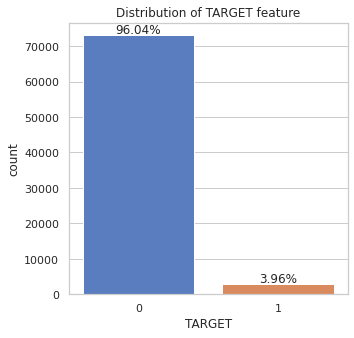

In [18]:
#distribution of target
countplot_target(train)

We can see that the dataset is highly imbalanced with only 3.96% being of unsatsified customers and 96.04% being satisfied customers

# var3 (Region)

In [19]:
np.array(sorted(train.var3.unique()))

array([-999999,       0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,
            13,      14,      15,      16,      17,      18,      19,
            20,      21,      22,      23,      24,      25,      26,
            27,      28,      29,      30,      31,      32,      33,
            34,      35,      36,      38,      40,      41,      42,
            43,      44,      45,      46,      47,      48,      49,
            50,      51,      52,      53,      54,      55,      56,
            57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      68,      69,      71,      72,
            73,      74,      76,      77,      78,      79,      81,
            82,      84,      85,      86,      87,      88,      89,
            90,      91,      93,      94,      95,      96,      97,
            98,      99,     100,     101,     102,     103,     104,
           105,     

In [20]:
print("The no. of unique values in var3 are %i"%(len(np.array(sorted(train.var3.unique())))))

The no. of unique values in var3 are 208


Here we can see that unique values range from 0 to 238 with exception being -999999(may be missing value). This may indicate nationality/region for a specific customer as 208 is a reasonable number for a global company like santander to be present in. This was further evidenced from the literature reviewed.

In [21]:
#getting the top 5 frequently occuring value of var3 in train data
train['var3'].value_counts()[:5]

 2         74165
 8           138
-999999      116
 9           110
 3           108
Name: var3, dtype: int64

In [22]:
#getting the top 5 frequently occuring value of var3 in train data
test['var3'].value_counts()[:5]

 2         73962
-999999      120
 8           116
 9           108
 3           107
Name: var3, dtype: int64

In [23]:
print("The highest occuring value in var3 (nationality) in train data is 2 which is %i (%.2f%%)."%(train['var3'].value_counts()[2],\
                                                                                  train['var3'].value_counts()[2]*100/test.shape[0]))
print("The highest occuring value in var3 (nationality) in test data is 2 which is %i (%.2f%%)."%(test['var3'].value_counts()[2],\
                                                                                  test['var3'].value_counts()[2]*100/test.shape[0]))

The highest occuring value in var3 (nationality) in train data is 2 which is 74165 (97.82%).
The highest occuring value in var3 (nationality) in test data is 2 which is 73962 (97.55%).


In [24]:
missing = dict(train['var3'].value_counts())[-999999]*100/train.shape[0]
missing_ = dict(test['var3'].value_counts())[-999999]*100/test.shape[0]
print("The percentage values that have extreme values for var3 in train and test data are %.3f%%, %.3f%% respectively"%(missing,missing_))

The percentage values that have extreme values for var3 in train and test data are 0.153%, 0.158% respectively


We will replace all values of -999999 with -1 and look at the frequency of occurences for each values (except 2).

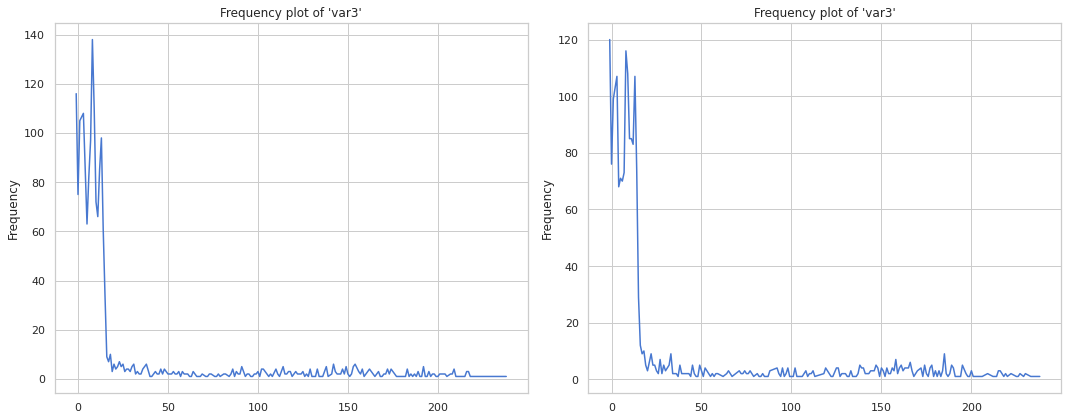

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'var3':
Value	 Count%
 8    7.439353
-1    6.253369
 9    5.929919
 3    5.822102
 1    5.660377
Name: var3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'var3':
Value	 Count%
184    0.053908
128    0.053908
41     0.053908
40     0.053908
106    0.053908
Name: var3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'var3':
Value	 Count%
-1     6.465517
 8     6.250000
 9     5.818966
 13    5.765086
 3     5.765086
Name: var3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in test dat

In [25]:
train['var3'].replace(-999999,-1,inplace=True)
test['var3'].replace(-999999,-1,inplace=True)
#plotting frequency with no 2 value for var3 and value_counts with percentage
valuecounts_plot('var3',train[ train['var3']!=2 ],test[ test['var3']!=2 ])

We can see from the above graphs that train and test data distributions for feature var3 is very similar.

The no. of customers that are unsatisfied are 2.
The no. of customers that are satisfied are 114.



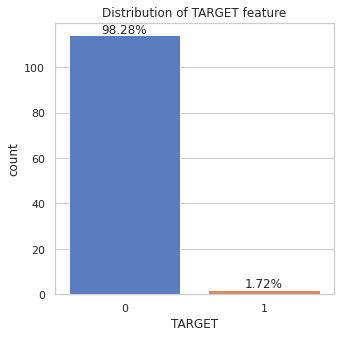

In [26]:
#distribution of target
mask = train[train['var3']==-1]
countplot_target(mask,h=1)

We can replace all the -1 values with 2 (most frequent category in this feature) for train and test since from train data also have customers that are unsatisfied and also the total number is very small

In [27]:
train['var3'].replace(-1,2,inplace=True)
test['var3'].replace(-1,2,inplace=True)

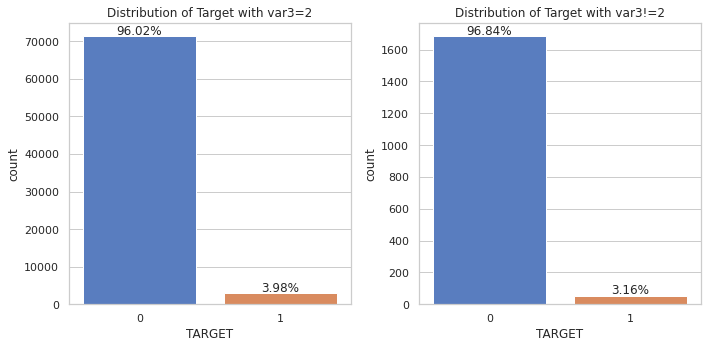

----------------------------------------------------------------------------------------------------
The no. of customers that are unsatisfied are 2953 for var3 = 2.
The no. of customers that are satisfied are 71328 for var3 = 2.

The no. of customers that are unsatisfied are 55 for var3! = 2.
The no. of customers that are satisfied are 1684 for var3! = 2.



In [28]:
# finding the ditribution of Target when var3 = 2
print('')
mask = train[ train['var3']==2 ]
total = mask.shape[0]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax = sns.countplot(mask['TARGET'],ax=ax1)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 500,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 
ax1.set_title("Distribution of Target with var3=2")
target_1 = mask[mask['TARGET']==1].shape[0]
target_0 = mask[mask['TARGET']==0].shape[0]



# finding the ditribution of Target when var3!= 2
mask = train[ train['var3']!=2 ]
total = mask.shape[0]
ax = sns.countplot(mask['TARGET'],ax=ax2)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 
ax2.set_title("Distribution of Target with var3!=2")
target_1_ = mask[mask['TARGET']==1].shape[0]
target_0_ = mask[mask['TARGET']==0].shape[0]
plt.tight_layout()
plt.show()
print('-'*100)
print("The no. of customers that are unsatisfied are %i for var3 = 2."%(target_1))
print("The no. of customers that are satisfied are %i for var3 = 2."%(target_0))
print('')
print("The no. of customers that are unsatisfied are %i for var3! = 2."%(target_1_))
print("The no. of customers that are satisfied are %i for var3! = 2."%(target_0_))
print('')

# var15 (Age)

In [29]:
max_ = train['var15'].max()
min_ = train['var15'].min()
print("The minimum value of var15 is %i and maximum value of var15 is %i."%(min_,max_ ))

The minimum value of var15 is 5 and maximum value of var15 is 105.


Since the value of var15 is from 5-105, it is safe to assume that this feature implies age of the customer. This is also evidenced in literature review.

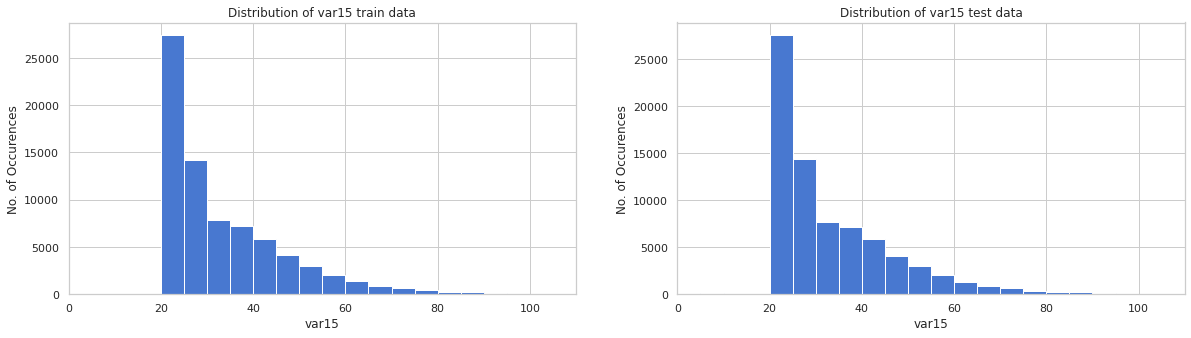


Customer whose age was below 30 constitued around 56.15% of all train data.
The min age in train data is 5 while max age was 105.

Customer whose age was below 30 constitued around 56.58% of all test data.
The min age in test data is 5 while max age was 105.


In [30]:
#plotting histplot for train and test data
histplot_comb('var15')


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
percentile = stats.percentileofscore(train['var15'].values,30)
print("Customer whose age was below 30 constitued around %.2f%% of all train data."%(percentile))
print("The min age in train data is %i while max age was %i."%(train.var15.min(),train.var15.max()))
print("")
percentile = stats.percentileofscore(test['var15'].values,30)
print("Customer whose age was below 30 constitued around %.2f%% of all test data."%(percentile))
print("The min age in test data is %i while max age was %i."%(test.var15.min(),test.var15.max()))

Both the train and test data had similiar distribution, both consisted of younger customers the most. Now we will see whether all younger people are satisfied.

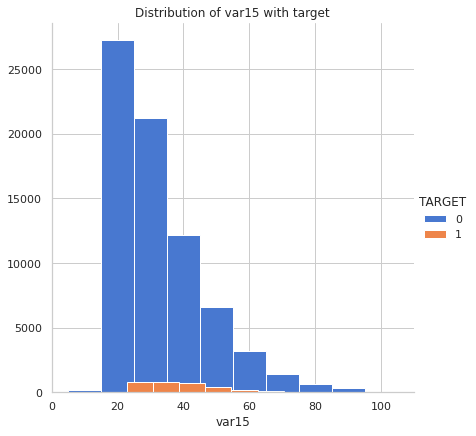

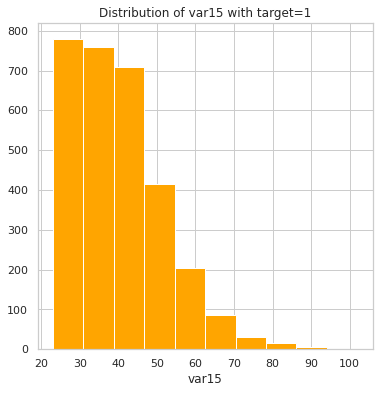

The minimum age of the unsatisfied customer is 23 and maximum age of the unsatisfied customer is 102 .


In [31]:
#plotting the distribution with target
sns.FacetGrid(data=train,hue='TARGET',height=6).map(plt.hist,'var15').add_legend()
plt.title("Distribution of var15 with target")
plt.show()

print("")
print("")

mask = train[(train['TARGET']==1)]
plt.figure(figsize=(6,6))
plt.hist(mask['var15'],color='orange')
plt.title("Distribution of var15 with target=1")
plt.xlabel('var15')
plt.show()

max_ = mask['var15'].max()
min_ = mask['var15'].min()
print("The minimum age of the unsatisfied customer is %i and maximum age of the unsatisfied customer is %i ."%(min_,max_ ))

We can see from the above diagram that most of the younger people are satisfied. So we can create a new feature which tells whether a customer is below 23 years old or not

In [32]:
#create a new feature which tells whether a customer is below 23 years old or not
for df in [train,test]:
    df['var15_below_23'] = np.zeros(df.shape[0],dtype=int)
    df.loc[df['var15']<23,'var15_below_23']=1

In [33]:
new_feature = ['var15_below_23']

In [34]:
#binning age feature into 5 bins
_,bins = pd.cut(train['var15'].values,5,retbins=True) #getting the bins
print(_ )

[(4.9, 25.0], (25.0, 45.0], (4.9, 25.0], (25.0, 45.0], (25.0, 45.0], ..., (45.0, 65.0], (25.0, 45.0], (4.9, 25.0], (4.9, 25.0], (45.0, 65.0]]
Length: 76020
Categories (5, interval[float64]): [(4.9, 25.0] < (25.0, 45.0] < (45.0, 65.0] < (65.0, 85.0] < (85.0, 105.0]]


These will be the bins that we will define.

In [35]:
#converting var15 values to bin values
train['var15'] = pd.cut(train['var15'].values,bins,labels=False)
test['var15'] = pd.cut(test['var15'].values,bins,labels=False)

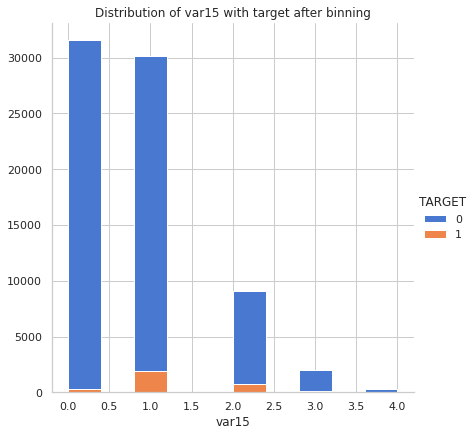

In [36]:
#plotting the binned feature
sns.FacetGrid(data=train,hue='TARGET',height=6).map(plt.hist,'var15').add_legend()
plt.title("Distribution of var15 with target after binning")
plt.show()

# var38 (Mortgage values)

In [37]:
print("The minimum value of var38 was found to be %.3f and the maximum value of var38 is %.3f"%(train.var38.min(),train.var38.max()))

The minimum value of var38 was found to be 5163.750 and the maximum value of var38 is 22034738.760


From the values above we can say that this feaure might represent mortgage values. This is also inferred from the literature review.

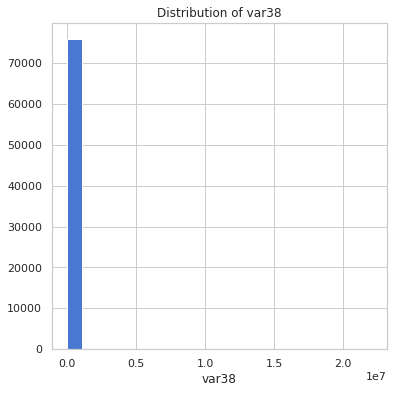

In [38]:
plt.figure(figsize=(6,6))
plt.hist(train['var38'],bins=20)
plt.title("Distribution of var38")
plt.xlabel('var38')
plt.show()

In [39]:
train.var38.value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
                 ...  
318211.440000        1
73069.260000         1
36425.370000         1
163515.900000        1
159395.520000        1
Name: var38, Length: 57736, dtype: int64

Here we are not able to get any informations as one value is having very high frequency of distribution. We will print out each percentile values.

In [40]:
for i in np.arange(0,1.1,0.1):
    print('%i percentile : %i'%(i*100,np.quantile(train.var38.values,i)))

0 percentile : 5163
10 percentile : 48070
20 percentile : 61496
30 percentile : 74152
40 percentile : 88571
50 percentile : 106409
60 percentile : 117310
70 percentile : 117310
80 percentile : 132859
90 percentile : 182585
100 percentile : 22034738


We can see that there is a huge difference between 0 percentile value and 10 percentile value. This is the same case for 90 percentile value and 100 percentile value.

In [41]:
#showing  0 to 10 percentile values
for i in np.arange(0,0.11,0.025):
    print('%.2f percentile : %i'%(i*100,np.quantile(train.var38.values,i)))

0.00 percentile : 5163
2.50 percentile : 32664
5.00 percentile : 39255
7.50 percentile : 44098
10.00 percentile : 48070


In [42]:
#showing 90 to 100 percentile values
for i in np.arange(0.9,1.01,0.025):
    print('%.2f percentile : %i'%(i*100,np.quantile(train.var38.values,i)))

90.00 percentile : 182585
92.50 percentile : 206707
95.00 percentile : 242780
97.50 percentile : 323173
100.00 percentile : 22034738


We can see that the min and max are far different in magnitude from the rest of them.

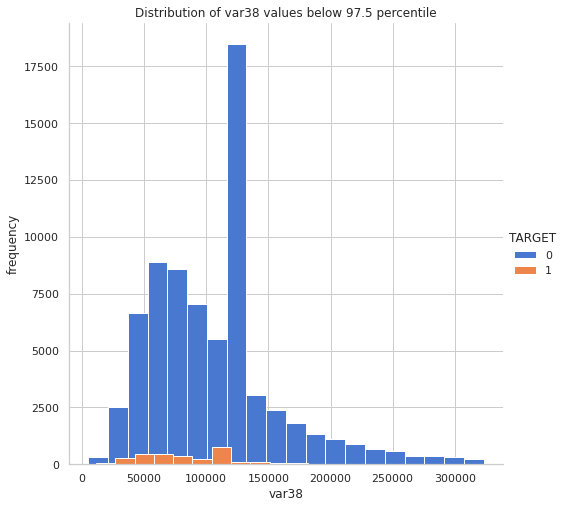

In [43]:
#plotting histplot for all values equal to or below 97.5 percentile value
mask = train[train['var38']<=np.quantile(train.var38.values,0.975)]
sns.FacetGrid(data=mask,hue='TARGET',height=7).map(plt.hist,'var38',bins=20).add_legend()
plt.title('Distribution of var38 values below 97.5 percentile')
plt.ylabel("frequency")
plt.show()

We can see that the above plot is right skewed with a outlandish peak between 100,000 and 150,000.
We can apply log transformation and check the resulting distribution.

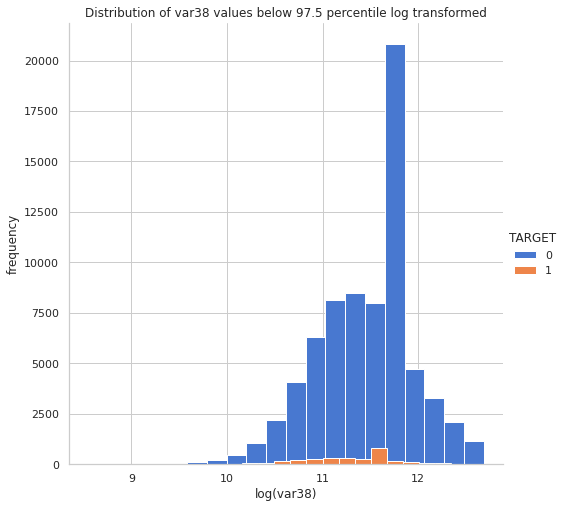

In [44]:
mask.loc[:,'var38'] = np.log(mask.var38).values
sns.FacetGrid(data=mask,hue='TARGET',height=7).map(plt.hist,'var38',bins=20).add_legend()
plt.title("Distribution of var38 values below 97.5 percentile log transformed")
plt.xlabel('log(var38)')
plt.ylabel("frequency")
plt.show()

This is much better than the former. So we apply the log transformation to the feature var38.

<Figure size 576x432 with 0 Axes>

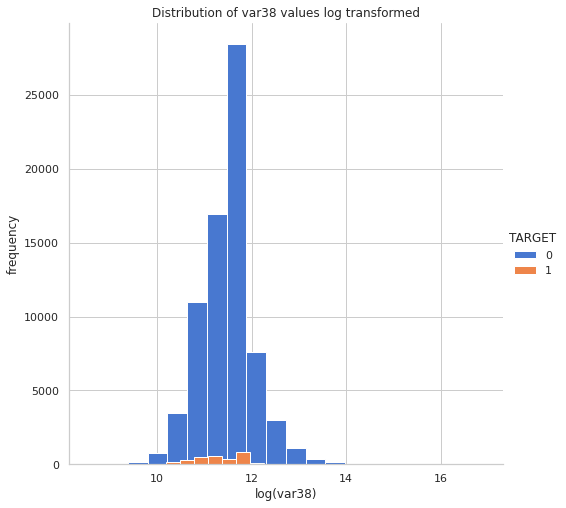

In [45]:
train.loc[:,'var38'] = np.log(train['var38']).values
plt.figure(figsize=(8,6))
sns.FacetGrid(data=train,hue='TARGET',height=7).map(plt.hist,'var38',bins=20).add_legend()
plt.title("Distribution of var38 values log transformed")
plt.xlabel('log(var38)')
plt.ylabel("frequency")
plt.show()

# Features with Keywords

In [46]:
train.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var41_comer_ult1',
       'imp_op_var41_comer_ult3', 'imp_op_var41_efect_ult1',
       'imp_op_var41_efect_ult3',
       ...
       'saldo_medio_var12_hace3', 'saldo_medio_var12_ult1',
       'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2',
       'saldo_medio_var13_corto_hace3', 'saldo_medio_var13_corto_ult1',
       'saldo_medio_var13_corto_ult3', 'var38', 'TARGET', 'var15_below_23'],
      dtype='object', length=144)

In [47]:
f_keywords = {col.split('_')[0] for col in train.columns if (len(col.split('_'))>1) & ~('var15' in col)} #extracting keywords in features and ignoring 'var15_below_23'
f_keywords

{'imp', 'ind', 'num', 'saldo'}

In [48]:
#counting the number of each keyword features
f_keywords = dict(zip(f_keywords,np.zeros(len(f_keywords),dtype=int)))
for key in f_keywords.keys():
    for col in train.columns:
        if key in col:
            f_keywords[key]+=1
f_keywords

{'saldo': 26, 'ind': 32, 'num': 64, 'imp': 14}

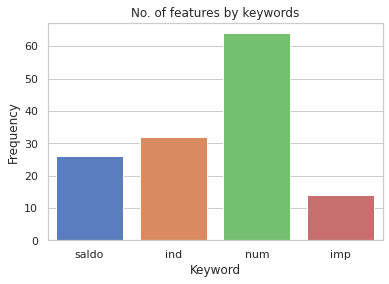

In [49]:
k = pd.Series(f_keywords)
sns.barplot(x=k.index,y=k.values)
plt.title("No. of features by keywords")
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()

We can see that no. of features with 'num' keyword is the highest while 'imp' had smaller representation.

In [50]:
# train.to_pickle('pickle_files/train_1.pkl')
# test.to_pickle('pickle_files/test_1.pkl')

In [51]:
train = pd.read_pickle('pickle_files/train_1.pkl')
test = pd.read_pickle('pickle_files/test_1.pkl')
train.shape,test.shape

((76020, 144), (75818, 143))

# imp features

In [52]:
imp = [col for col in train.columns if 'imp' in col]
print("The number of features with imp keyword are: %i"%(len(imp)))
imp

The number of features with imp keyword are: 14


['imp_ent_var16_ult1',
 'imp_op_var39_comer_ult1',
 'imp_op_var39_comer_ult3',
 'imp_op_var41_comer_ult1',
 'imp_op_var41_comer_ult3',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_op_var39_ult1',
 'imp_aport_var13_hace3',
 'imp_var43_emit_ult1',
 'imp_trans_var37_ult1']

'imp' likey is shortened word for importe which is Spanish for amount(inferred from literature review). Now we randomily select 2 features from it and explore further.

In [53]:
random.seed(a=0) #setting seed to 2 so that random chosen features are always the same
imp_feat = random.sample(imp,2)
print("The features that are randomily chosen are '%s' and '%s'"%(imp_feat[0],imp_feat[1]))

The features that are randomily chosen are 'imp_trans_var37_ult1' and 'imp_op_var41_efect_ult3'


# 'imp_trans_var37_ult1'

In [54]:
col = imp_feat[0]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'imp_trans_var37_ult1' are 0.0 and 2310003.0
The min and max value in test data for 'imp_trans_var37_ult1' are 0.0 and 3000000.0


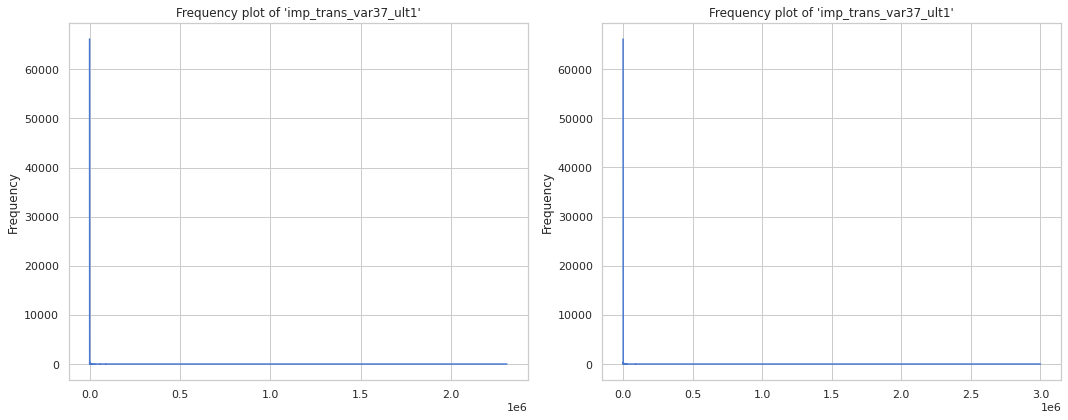

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'imp_trans_var37_ult1':
Value	 Count%
0.0       87.069192
300.0      0.536701
600.0      0.420942
1500.0     0.361747
150.0      0.344646
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'imp_trans_var37_ult1':
Value	 Count%
459885.90    0.001315
829.08       0.001315
1350.72      0.001315
25.02        0.001315
31750.38     0.001315
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'imp_trans_var37_ult1':
Value	 Count%
0.0       87.235221
300.0      0.563191
600.0      0.465589
1500.0     0.391728
3000.0     0.319185
Name: imp_trans_var37_u

In [55]:
#potting frequency plot
valuecounts_plot(train=train,test=test,col=col)

We can see that 87% of train and test data have the value 0.

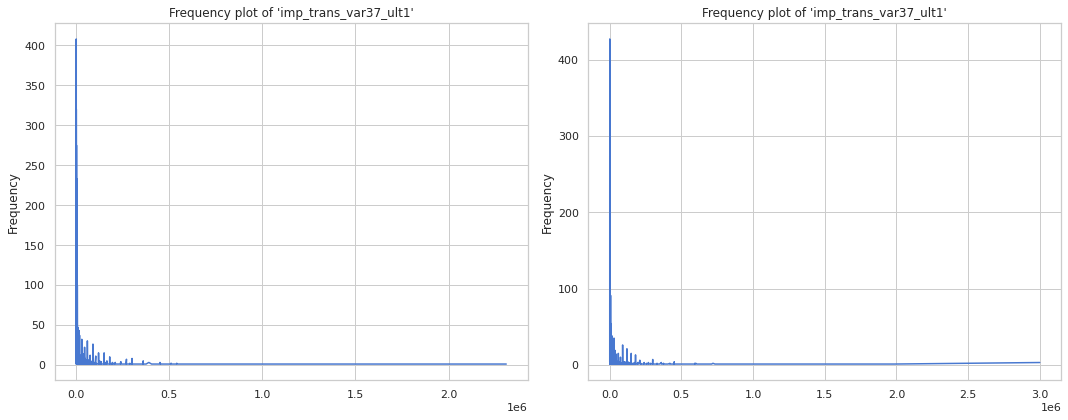

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'imp_trans_var37_ult1':
Value	 Count%
300.0     4.150560
600.0     3.255341
1500.0    2.797558
150.0     2.665310
900.0     2.492370
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'imp_trans_var37_ult1':
Value	 Count%
1260.63    0.010173
3020.40    0.010173
576.90     0.010173
104.97     0.010173
6165.00    0.010173
Name: imp_trans_var37_ult1, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'imp_trans_var37_ult1':
Value	 Count%
300.0     4.412069
600.0     3.647448
1500.0    3.068816
3000.0    2.500517
900.0     2.448853
Name: imp_trans_var37_ult1, dtype: float64


In [56]:
col = imp_feat[0]
#plotting frequency plots with no zero (most occuring) values
valuecounts_plot(train = train[train[col]!=0], test = test[test[col]!=0],col=col)

We can see that most of the values are in the range are below 5e5 even if we do not consider 0 (most frequent value).  And the distribution is very similiar in both train and test data.

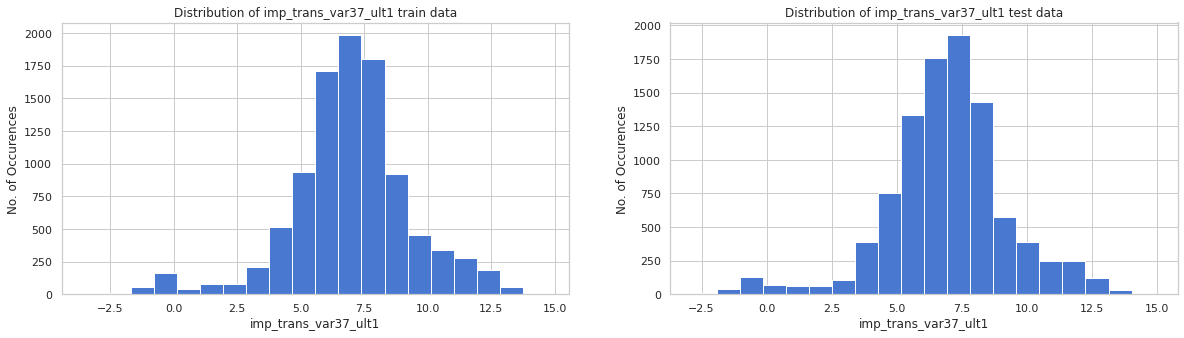

In [57]:
#apply log transformation and not including 0
df = train[train[col]!=0].copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test[test[col]!=0].copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

We can see that above distriubtion for train and test data looks a lot like guassian distribution(not entirely guassian).

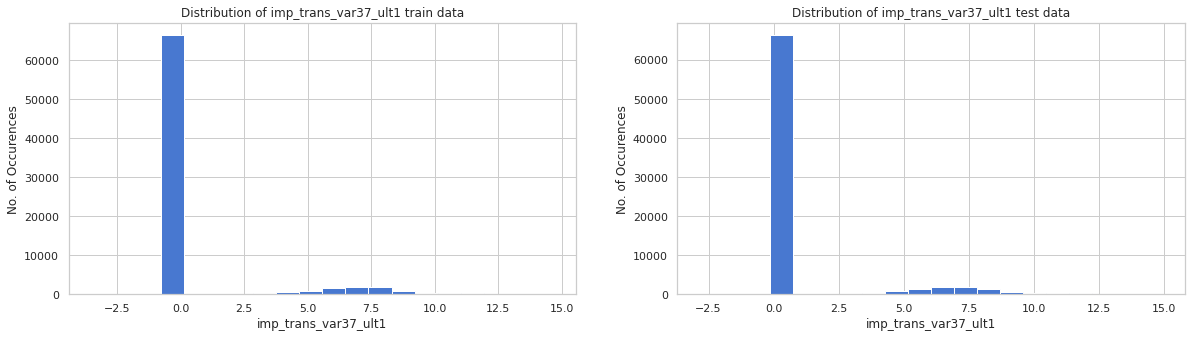

In [58]:
#apply log transformation and including 0
df = train.copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test.copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

Both of the train and test data have similiar distribution with a peak in 0. Now we can check the same for the next feature of imp we have randomily sampled.

# 'imp_op_var41_efect_ult3'

In [59]:
col = imp_feat[1]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'imp_op_var41_efect_ult3' are 0.0 and 131100.0
The min and max value in test data for 'imp_op_var41_efect_ult3' are 0.0 and 67950.0


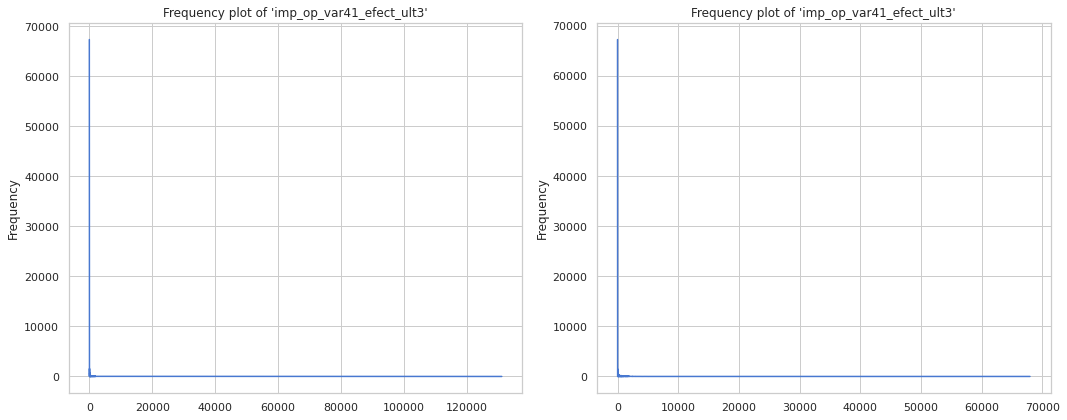

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'imp_op_var41_efect_ult3':
Value	 Count%
0.0      88.624046
60.0      2.065246
120.0     0.912918
180.0     0.463036
240.0     0.367009
Name: imp_op_var41_efect_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'imp_op_var41_efect_ult3':
Value	 Count%
628.35      0.001315
27570.00    0.001315
96.87       0.001315
5550.00     0.001315
8190.00     0.001315
Name: imp_op_var41_efect_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'imp_op_var41_efect_ult3':
Value	 Count%
0.0      88.679469
60.0      1.933578
120.0     1.006357
180.0     0.484054
300.0     0.378538
Name: imp_op_var41_efec

In [60]:
#potting frequency plot
valuecounts_plot(train=train,test=test,col=col)

Here also 0 is the high frequent value accounting for atleast 88% of the entire data for both train and test.

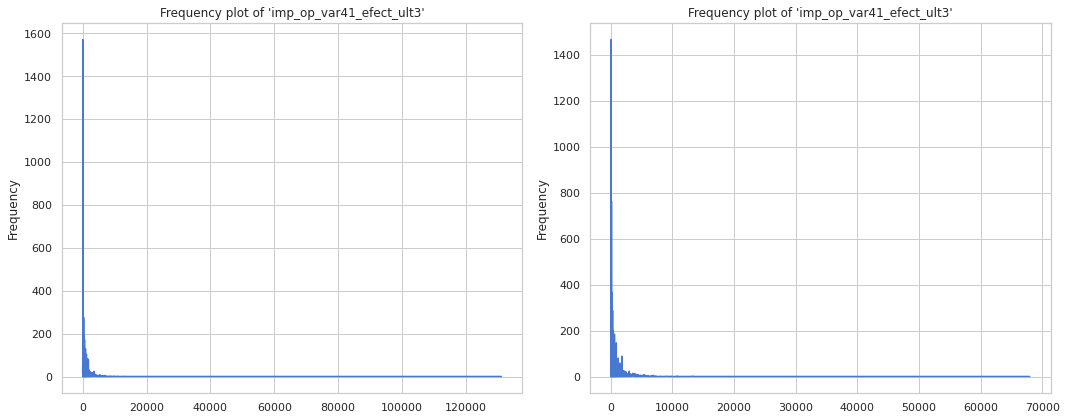

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'imp_op_var41_efect_ult3':
Value	 Count%
60.0     18.154487
120.0     8.024977
180.0     4.070305
240.0     3.226179
300.0     3.168363
Name: imp_op_var41_efect_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'imp_op_var41_efect_ult3':
Value	 Count%
8910.00    0.011563
6990.00    0.011563
456.00     0.011563
87.00      0.011563
2364.06    0.011563
Name: imp_op_var41_efect_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'imp_op_var41_efect_ult3':
Value	 Count%
60.0     17.080275
120.0     8.889666
180.0     4.275894
300.0     3.343819
240.0     3.134102
Name: imp_op_var41_efect_ult

In [61]:
col = imp_feat[1]
#plotting frequency plots with no zero (most occuring) values
valuecounts_plot(train = train[train[col]!=0], test = test[test[col]!=0],col=col)

We can see that most of the values are in the range are below 20k even if we do not consider 0 (most frequent value).

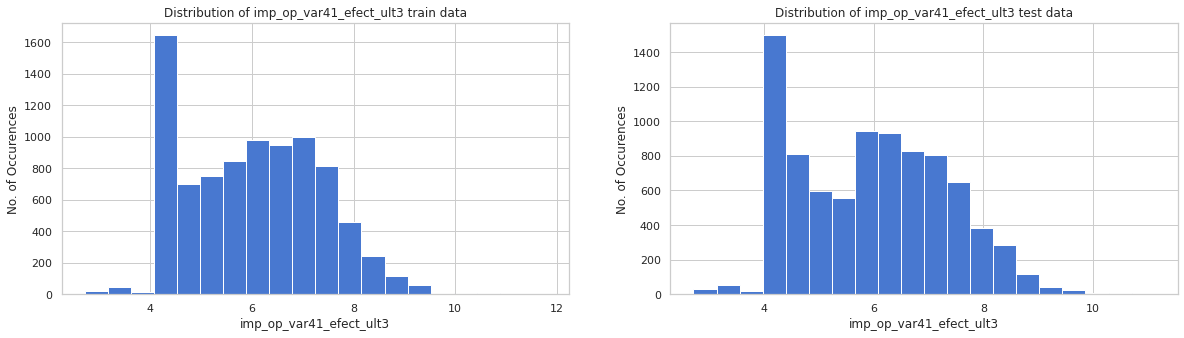

In [62]:
#apply log transformation and not including 0
df = train[train[col]!=0].copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test[test[col]!=0].copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

We can see that above distriubtion for train and test data looks similiar (if we don't consider 0) after applying log transformation.

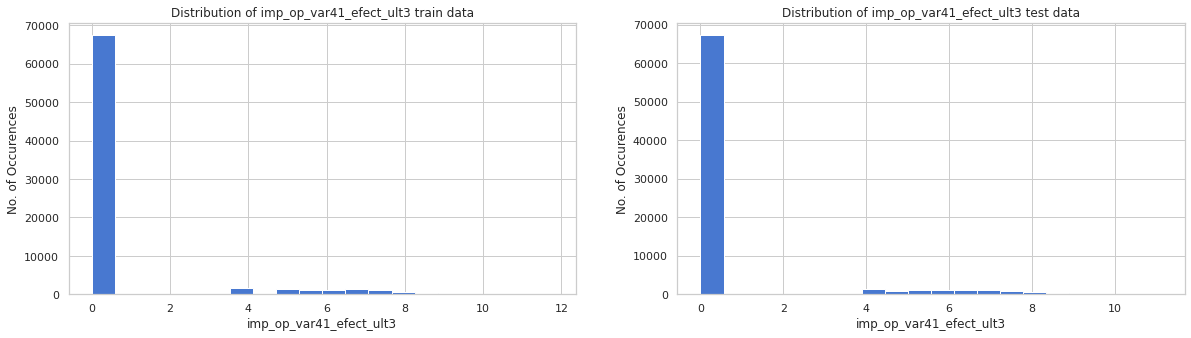

In [63]:
#apply log transformation and including 0
df = train.copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test.copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

Both of the train and test data have similiar distribution with a peak in 0.  
We can also say that every imp features follows a similiar distribution like above randomily sampled two features. (zero most frequent).

# Strategy for 'imp' features
1. We can create a new dataset with log transformed (excluding 0) imp features. 
2. We can also create another dataset with no transformations applied (leaving as it is).

# saldo keyword features

In [64]:
imp = [col for col in train.columns if 'saldo' in col]
print("The number of features with saldo keyword are: %i"%(len(imp)))
imp

The number of features with saldo keyword are: 26


['saldo_var5',
 'saldo_var8',
 'saldo_var12',
 'saldo_var13_corto',
 'saldo_var13',
 'saldo_var24',
 'saldo_var26',
 'saldo_var25',
 'saldo_var30',
 'saldo_var37',
 'saldo_var42',
 'saldo_medio_var5_hace2',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_medio_var8_hace2',
 'saldo_medio_var8_ult1',
 'saldo_medio_var8_ult3',
 'saldo_medio_var12_hace2',
 'saldo_medio_var12_hace3',
 'saldo_medio_var12_ult1',
 'saldo_medio_var12_ult3',
 'saldo_medio_var13_corto_hace2',
 'saldo_medio_var13_corto_hace3',
 'saldo_medio_var13_corto_ult1',
 'saldo_medio_var13_corto_ult3']

Now we randomily select 2 features from it and explore further.

In [65]:
random.seed(a=77) #setting seed so that random chosen features are always the same
imp_feat = random.sample(imp,2)
print("The features that are randomily chosen are '%s' and '%s'"%(imp_feat[0],imp_feat[1]))

The features that are randomily chosen are 'saldo_medio_var13_corto_ult3' and 'saldo_var30'


# 'saldo_medio_var13_corto_ult3'

In [66]:
col = imp_feat[0]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'saldo_medio_var13_corto_ult3' are 0.0 and 450000.0
The min and max value in test data for 'saldo_medio_var13_corto_ult3' are 0.0 and 450000.0


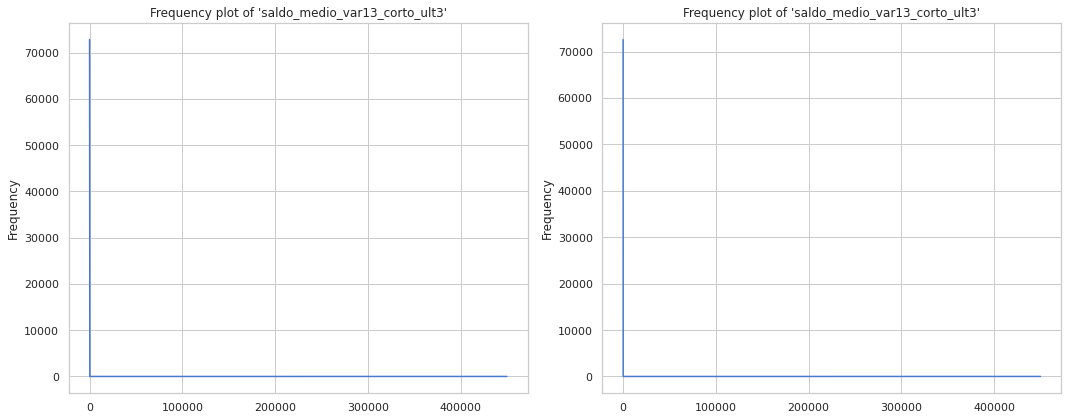

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
0.00         95.811629
20322.57      0.011839
240.75        0.009208
41333.34      0.009208
261290.34     0.007893
Name: saldo_medio_var13_corto_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
442741.95    0.001315
197844.84    0.001315
258333.33    0.001315
16709.67     0.001315
16983.90     0.001315
Name: saldo_medio_var13_corto_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
0.00         95.750350
150000.00     0.011871
58064.52      0.010552

In [67]:
#potting frequency plot
valuecounts_plot(train=train,test=test,col=col)

We can see that around 96% of train and test data have the value 0.

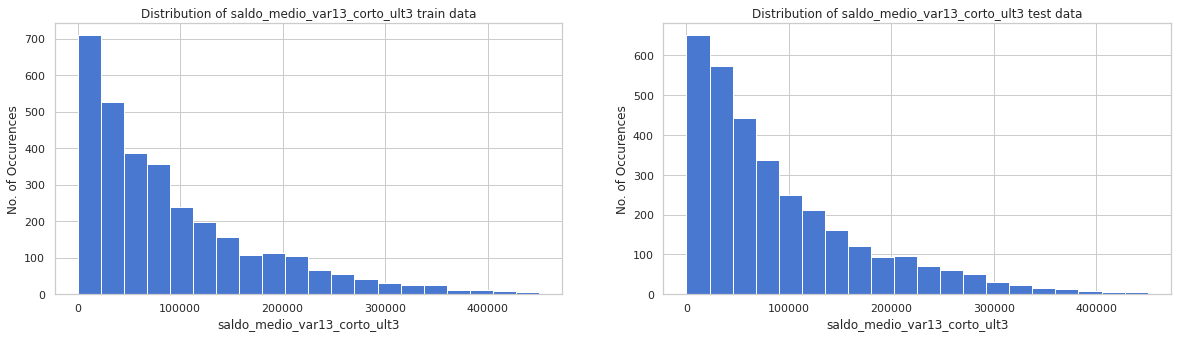

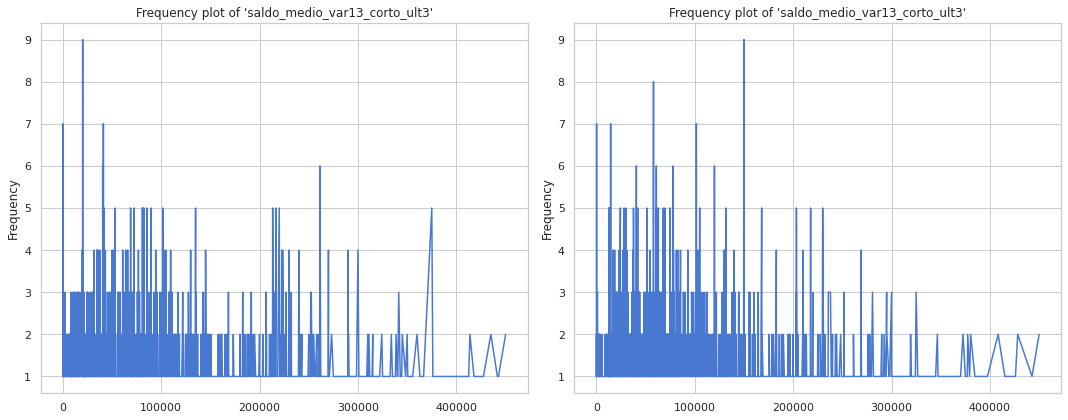

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
20322.57     0.282663
41333.34     0.219849
240.75       0.219849
40645.17     0.188442
261290.34    0.188442
Name: saldo_medio_var13_corto_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
46500.00    0.031407
9386.43     0.031407
54400.02    0.031407
6517.23     0.031407
12864.00    0.031407
Name: saldo_medio_var13_corto_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'saldo_medio_var13_corto_ult3':
Value	 Count%
150000.00    0.279330
58064.52     0.248293
211.11       0.217256
14516.13    

In [68]:
col = imp_feat[0]
#plotting frequency plots with no zero (most occuring) values
histplot_comb(col,train[train[col]!=0],test[test[col]!=0])
valuecounts_plot(train = train[train[col]!=0], test = test[test[col]!=0],col=col)


We can see that distribution is similiar in both train and test data and both are right skewed.

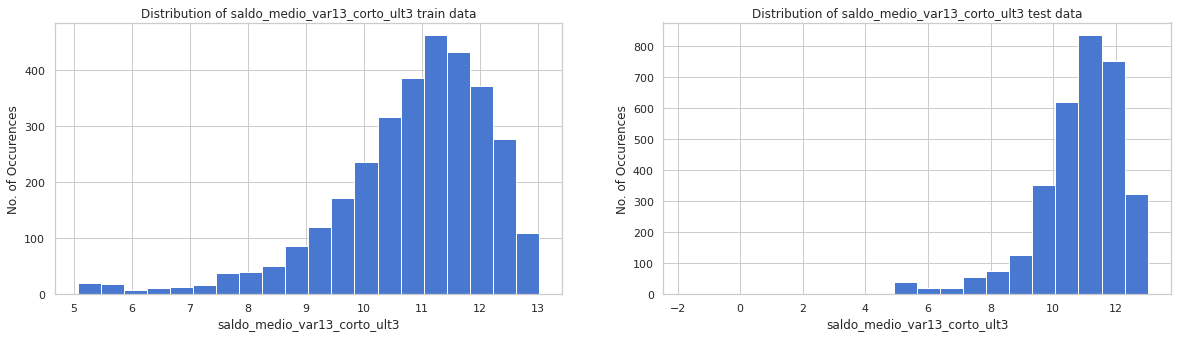

In [69]:
#apply log transformation and not including 0
df = train[train[col]!=0].copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test[test[col]!=0].copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

Test and train data after applying log transformation (excluding most frequent value) is similiar in distribution

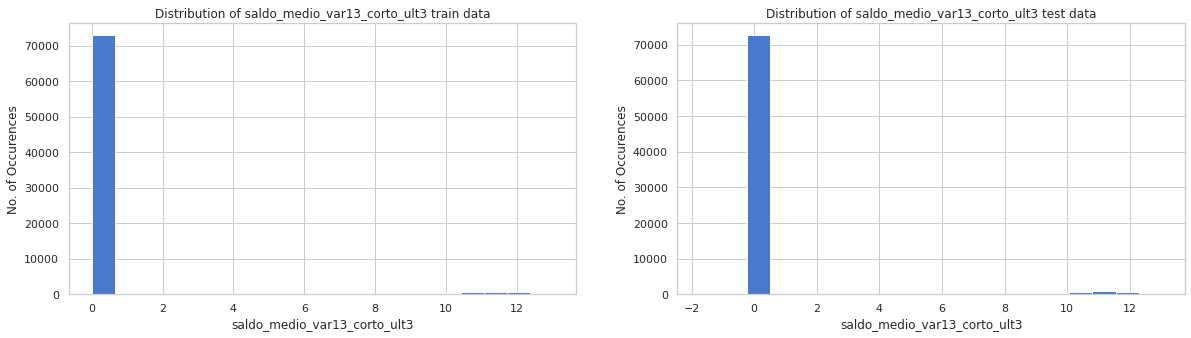

In [70]:
#apply log transformation and including 0
df = train.copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test.copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

Both of the train and test data have similiar distribution(after log transformation) with a peak in 0. Now we can check the same for the next feature we have randomily sampled.

# 'saldo_var30'

In [71]:
col = imp_feat[1]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'saldo_var30' are -4942.3 and 3458077.3
The min and max value in test data for 'saldo_var30' are -3972.2 and 4212656.1


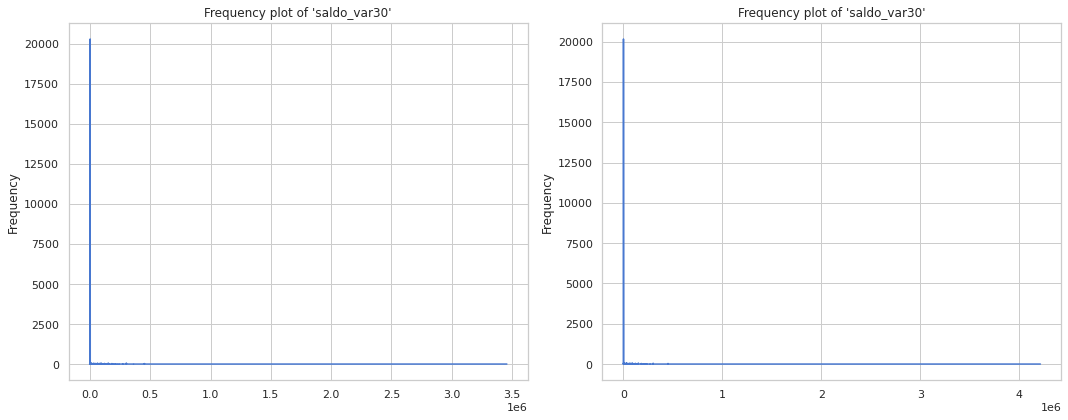

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'saldo_var30':
Value	 Count%
0.0     26.716654
3.0     24.059458
90.0     6.887661
30.0     2.108656
15.0     1.942910
Name: saldo_var30, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'saldo_var30':
Value	 Count%
2535.84      0.001315
143461.68    0.001315
499.02       0.001315
137.25       0.001315
2223.42      0.001315
Name: saldo_var30, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'saldo_var30':
Value	 Count%
0.0     26.603181
3.0     24.438788
90.0     6.958770
30.0     2.079981
15.0     1.996887
Name: saldo_var30, dtype: float64
******************************************************

In [72]:
#potting frequency plot
valuecounts_plot(train=train,test=test,col=col)

Here also 0 is the high frequent value accounting for atleast 26.7% of the entire data for both train and test closely followed by 3.

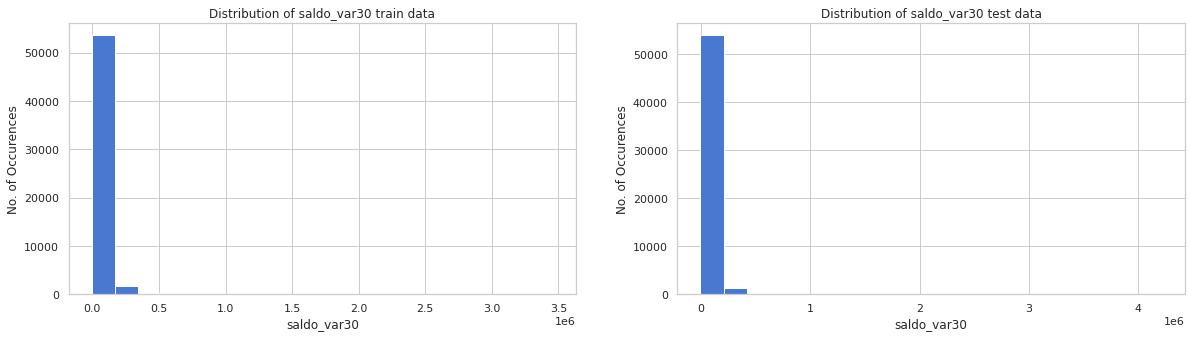

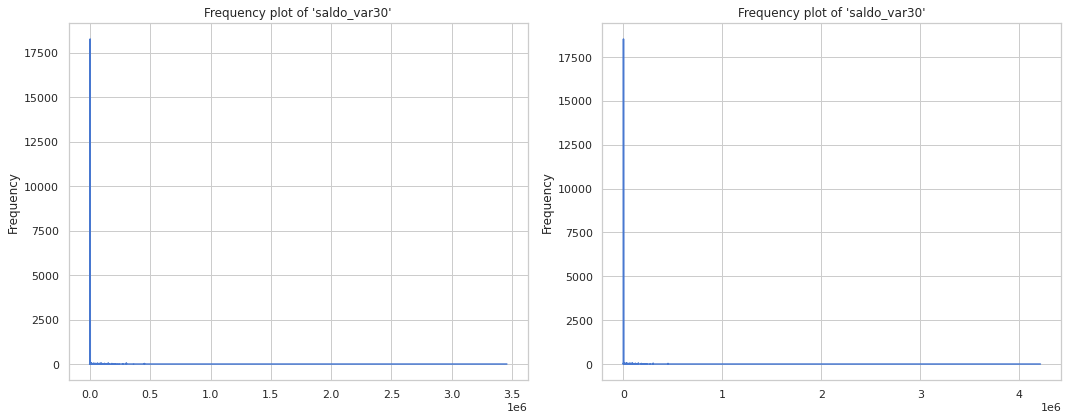

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'saldo_var30':
Value	 Count%
3.0     32.830731
90.0     9.398672
30.0     2.877401
15.0     2.651230
6.0      1.662179
Name: saldo_var30, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'saldo_var30':
Value	 Count%
1079.97      0.001795
3393.72      0.001795
9082.44      0.001795
3537.39      0.001795
305767.80    0.001795
Name: saldo_var30, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'saldo_var30':
Value	 Count%
3.0     33.296794
90.0     9.481024
30.0     2.833884
15.0     2.720673
6.0      1.604730
Name: saldo_var30, dtype: float64
******************************************************

In [73]:
col = imp_feat[1]
#plotting frequency plots with no zero (most occuring) values
histplot_comb(col,train[train[col]!=0],test[test[col]!=0])
valuecounts_plot(train = train[train[col]!=0], test = test[test[col]!=0],col=col)


We can see that most of the values are between 0 and 500k.

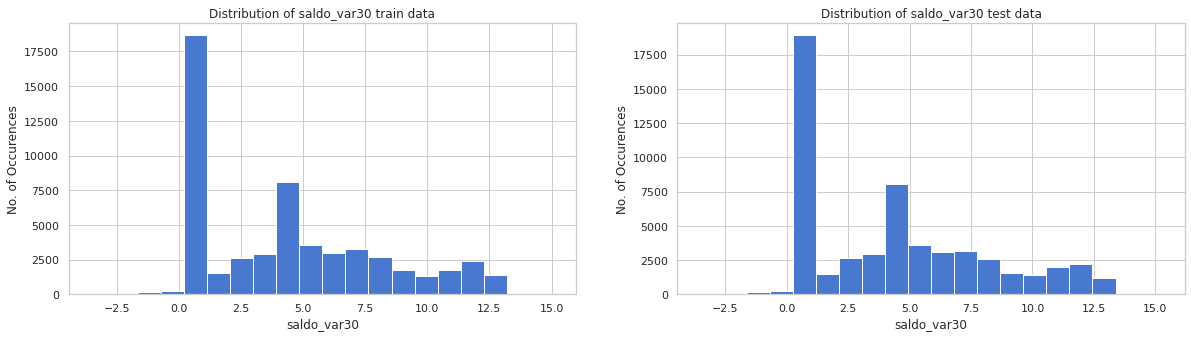

In [74]:
#apply log transformation and not including 0
df = train[train[col]!=0].copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test[test[col]!=0].copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

We can see that above distriubtion for train and test data looks similiar (if we don't consider 0) after applying log transformation.

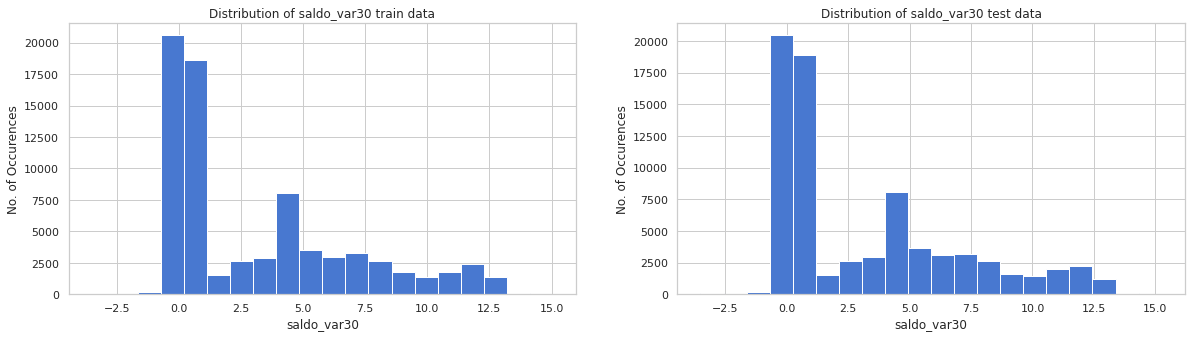

In [75]:
#apply log transformation and including 0
df = train.copy()
df.loc[df[col]!=0,col] = np.log(df.loc[df[col]!=0,col])
df1 = test.copy()
df1.loc[df1[col]!=0,col] = np.log(df1.loc[df1[col]!=0,col])
histplot_comb(col,df,df1)

Both of the train and test data have similiar distribution.(after log transformation)  
We can also say that every saldo features follows a similiar distribution like above randomily sampled two features. (zero most frequent).

# Strategy for 'saldo' features
1. We can create a new dataset with log transformed (excluding 0) saldo features. 
2. We can also create another dataset with no transformations applied (leaving as it is).

# num features

In [76]:
imp = [col for col in train.columns if 'num' in col]
print("The number of features with 'num' keyword are: %i"%(len(imp)))
imp

The number of features with 'num' keyword are: 64


['num_var1_0',
 'num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13',
 'num_var14_0',
 'num_var24_0',
 'num_var24',
 'num_var26',
 'num_var25',
 'num_op_var41_hace2',
 'num_op_var41_hace3',
 'num_op_var41_ult1',
 'num_op_var41_ult3',
 'num_op_var39_hace2',
 'num_op_var39_hace3',
 'num_op_var39_ult1',
 'num_op_var39_ult3',
 'num_var30_0',
 'num_var30',
 'num_var35',
 'num_var37_med_ult2',
 'num_var37',
 'num_var39_0',
 'num_var40_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'num_aport_var13_hace3',
 'num_ent_var16_ult1',
 'num_var22_hace2',
 'num_var22_hace3',
 'num_var22_ult1',
 'num_var22_ult3',
 'num_med_var22_ult3',
 'num_med_var45_ult3',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var39_vig_ult3',
 'num_op_var39_comer_ult1',
 'num_op_var39_comer_ult3',
 'num_op_var41_co

Now we randomily select 2 features from it and explore further.

In [77]:
random.seed(a=420) #setting seed so that random chosen features are always the same
imp_feat = random.sample(imp,2)
print("The features that are randomily chosen are '%s' and '%s'"%(imp_feat[0],imp_feat[1]))

The features that are randomily chosen are 'num_var5' and 'num_meses_var12_ult3'


# 'num_var5'

In [78]:
col = imp_feat[0]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'num_var5' are 0.0 and 15.0
The min and max value in test data for 'num_var5' are 0.0 and 12.0


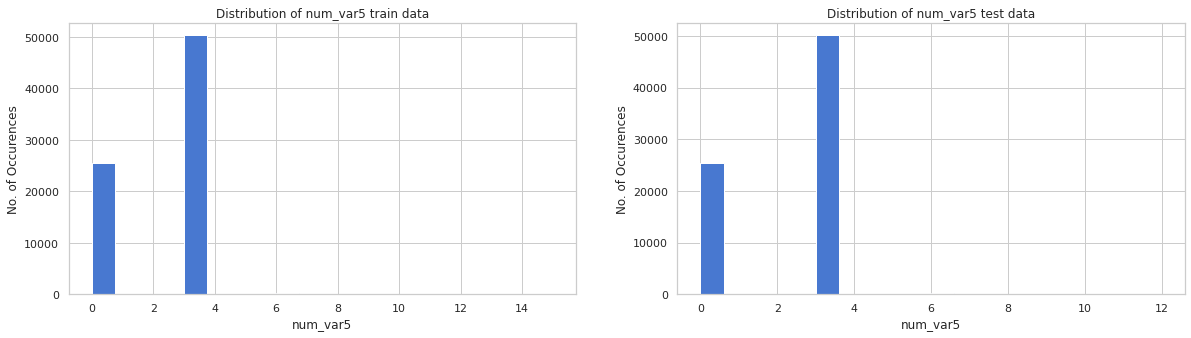

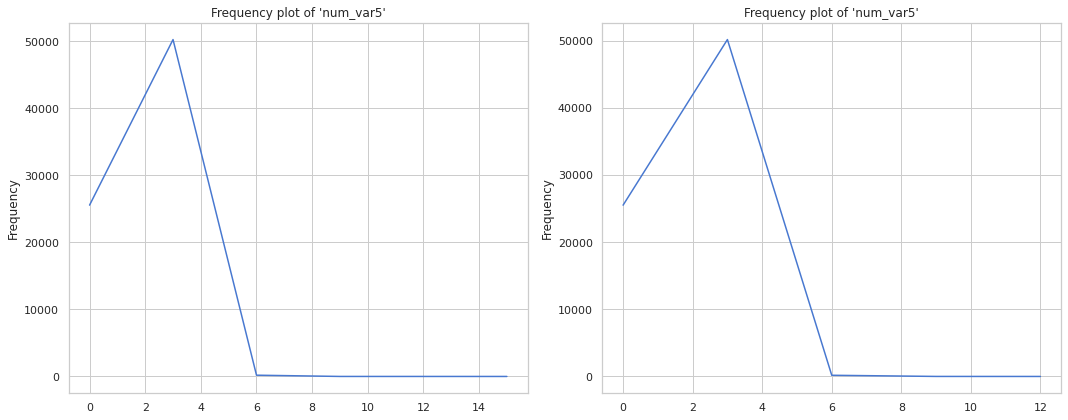

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'num_var5':
Value	 Count%
3     66.120758
0     33.624046
6      0.249934
9      0.003946
15     0.001315
Name: num_var5, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'num_var5':
Value	 Count%
3     66.120758
0     33.624046
6      0.249934
9      0.003946
15     0.001315
Name: num_var5, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'num_var5':
Value	 Count%
3     66.133372
0     33.625260
6      0.233454
9      0.006595
12     0.001319
Name: num_var5, dtype: float64
****************************************************************************************************
Percentage value coun

In [79]:
#potting frequency plot
histplot_comb(col,train,test)
valuecounts_plot(train=train,test=test,col=col)


There are only 5 unqiue values for this feature suggesting it is a categorical feature. Another important feature is that they are all multiples of 3. '3' has the highest representation with 66%. We can also see that 15 does not occur in test data.

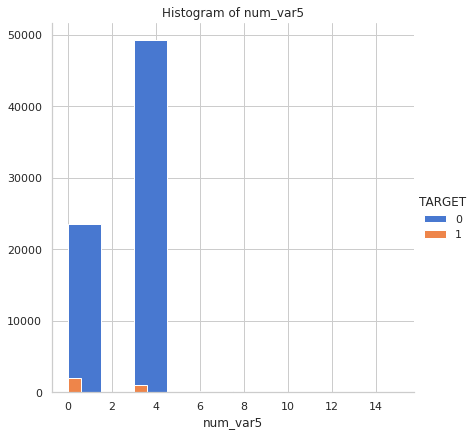

The percent of unsatisfied customers when 'num_var5'==0 is 7.664%
The percent of unsatisfied customers when 'num_var5'==3 is 2.073%
The percent of unsatisfied customers when 'num_var5'==6 is 3.684%
The percent of unsatisfied customers when 'num_var5'==9 is 0.000%
The percent of unsatisfied customers when 'num_var5'==15 is 0.000%


In [80]:
sns.FacetGrid(data=train,hue='TARGET',height=6).map(plt.hist,col).add_legend()
plt.title('Histogram of %s'%(col))
plt.show()
for i in train[col].unique():
    print("The percent of unsatisfied customers when '%s'==%i is %.3f%%"%\
      (col,i,train[(train[y_col]==1)&(train[col]==i)][col].shape[0]*100/\
       train[train[col]==i].shape[0]))

# 'num_meses_var12_ult3'

In [81]:
col = imp_feat[1]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'num_meses_var12_ult3' are 0.0 and 3.0
The min and max value in test data for 'num_meses_var12_ult3' are 0.0 and 3.0


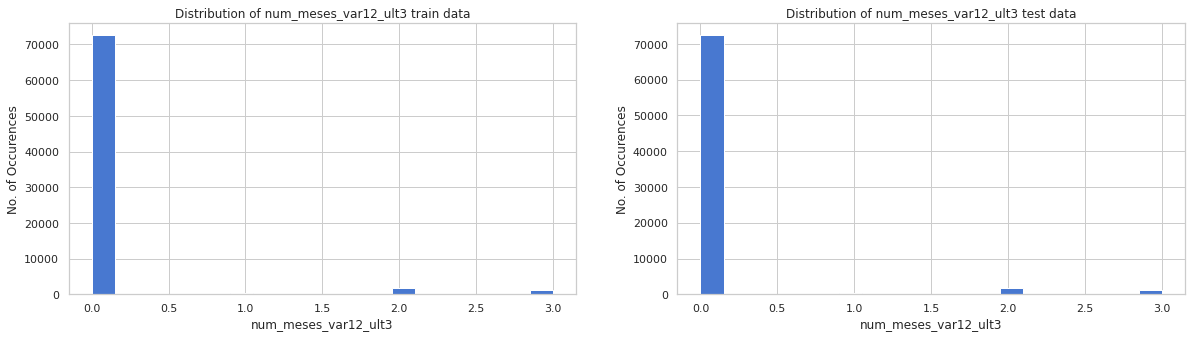

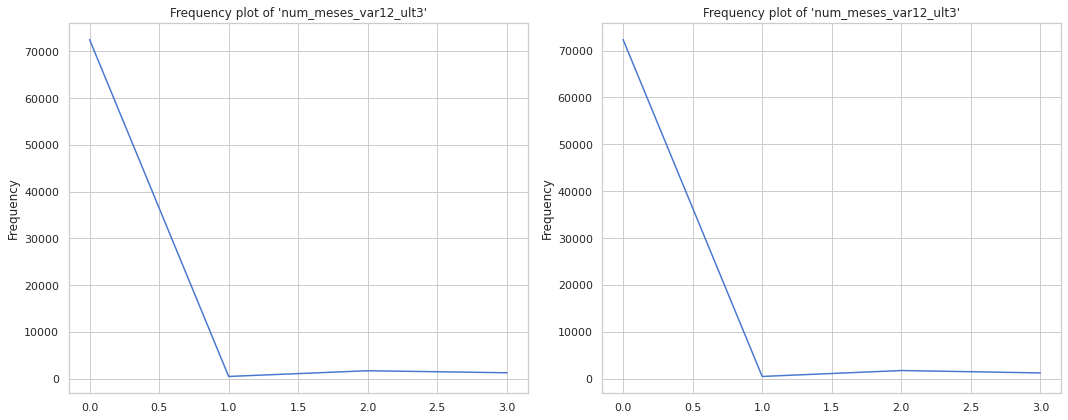

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'num_meses_var12_ult3':
Value	 Count%
0    95.418311
2     2.250723
3     1.686398
1     0.644567
Name: num_meses_var12_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'num_meses_var12_ult3':
Value	 Count%
0    95.418311
2     2.250723
3     1.686398
1     0.644567
Name: num_meses_var12_ult3, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'num_meses_var12_ult3':
Value	 Count%
0    95.439078
2     2.300245
3     1.627582
1     0.633095
Name: num_meses_var12_ult3, dtype: float64
****************************************************************************************************
Percentag

In [82]:
#potting frequency plot
histplot_comb(col,train,test)
valuecounts_plot(train=train,test=test,col=col)


Here also 0 is the high frequent value accounting for atleast 95% of the entire data for both train and test. The value_counts% is similiar in range for both train and test data. And also the no. of unique values is only 5 indicating that this is also a categorical feature.

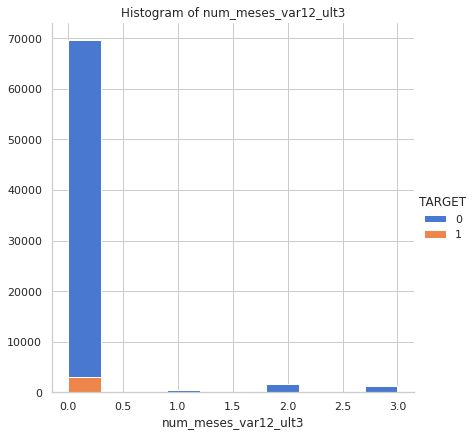

The percent of unsatisfied customers when 'num_meses_var12_ult3'==0 is 4.097%
The percent of unsatisfied customers when 'num_meses_var12_ult3'==1 is 1.633%
The percent of unsatisfied customers when 'num_meses_var12_ult3'==2 is 0.935%
The percent of unsatisfied customers when 'num_meses_var12_ult3'==3 is 0.936%


In [83]:
sns.FacetGrid(data=train,hue='TARGET',height=6).map(plt.hist,col).add_legend()
plt.title('Histogram of %s'%(col))
plt.show()
for i in train[col].unique():
    print("The percent of unsatisfied customers when '%s'==%i is %.3f%%"%\
      (col,i,train[(train[y_col]==1)&(train[col]==i)][col].shape[0]*100/\
       train[train[col]==i].shape[0]))

In [84]:
#analysing every feat of num
for feat in imp:
    print("%s \t unique-values:%i \t dtype:%s"%(feat,train[feat].nunique(),train[feat].dtype))

num_var1_0 	 unique-values:3 	 dtype:int64
num_var4 	 unique-values:8 	 dtype:int64
num_var5_0 	 unique-values:5 	 dtype:int64
num_var5 	 unique-values:5 	 dtype:int64
num_var8_0 	 unique-values:3 	 dtype:int64
num_var8 	 unique-values:2 	 dtype:int64
num_var12_0 	 unique-values:6 	 dtype:int64
num_var12 	 unique-values:4 	 dtype:int64
num_var13_0 	 unique-values:7 	 dtype:int64
num_var13_corto_0 	 unique-values:3 	 dtype:int64
num_var13_corto 	 unique-values:3 	 dtype:int64
num_var13_largo_0 	 unique-values:7 	 dtype:int64
num_var13 	 unique-values:7 	 dtype:int64
num_var14_0 	 unique-values:5 	 dtype:int64
num_var24_0 	 unique-values:4 	 dtype:int64
num_var24 	 unique-values:3 	 dtype:int64
num_var26 	 unique-values:9 	 dtype:int64
num_var25 	 unique-values:9 	 dtype:int64
num_op_var41_hace2 	 unique-values:51 	 dtype:int64
num_op_var41_hace3 	 unique-values:22 	 dtype:int64
num_op_var41_ult1 	 unique-values:68 	 dtype:int64
num_op_var41_ult3 	 unique-values:96 	 dtype:int64
num_op_v

We can see from above that the no. unique values was max for 'num_var45_ult3' with 172. Still these can be categorical as no. of datapoints is in the range 70k. 

# Strategy for 'num' features
1. We will put a threshold on what is the maximum number of unique values that is allowed so that a feature can be defined as categorical. We will set the threshold as 10.
2. We can create new datasets with target encoding and leaving the features as it is for 'num' features.(This only applies to categorical features that are defined baesd on the rule above)


# 'ind' features

In [85]:
imp = [col for col in train.columns if 'ind' in col]
print("The number of features with 'ind' keyword are: %i"%(len(imp)))
imp

The number of features with 'ind' keyword are: 32


['ind_var1_0',
 'ind_var5_0',
 'ind_var5',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13',
 'ind_var14_0',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_cte',
 'ind_var26',
 'ind_var25',
 'ind_var30_0',
 'ind_var30',
 'ind_var37_cte',
 'ind_var37',
 'ind_var39_0',
 'ind_var40_0',
 'ind_var41_0',
 'ind_var10_ult1',
 'ind_var10cte_ult1',
 'ind_var9_cte_ult1',
 'ind_var9_ult1',
 'ind_var43_emit_ult1',
 'ind_var43_recib_ult1']

Now we randomily select 2 features from it and explore further.

In [86]:
random.seed(a=420) #setting seed so that random chosen features are always the same
imp_feat = random.sample(imp,2)
print("The features that are randomily chosen are '%s' and '%s'"%(imp_feat[0],imp_feat[1]))

The features that are randomily chosen are 'ind_var5_0' and 'ind_var39_0'


# 'ind_var5_0'

In [87]:
col = imp_feat[0]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'ind_var5_0' are 0.0 and 1.0
The min and max value in test data for 'ind_var5_0' are 0.0 and 1.0


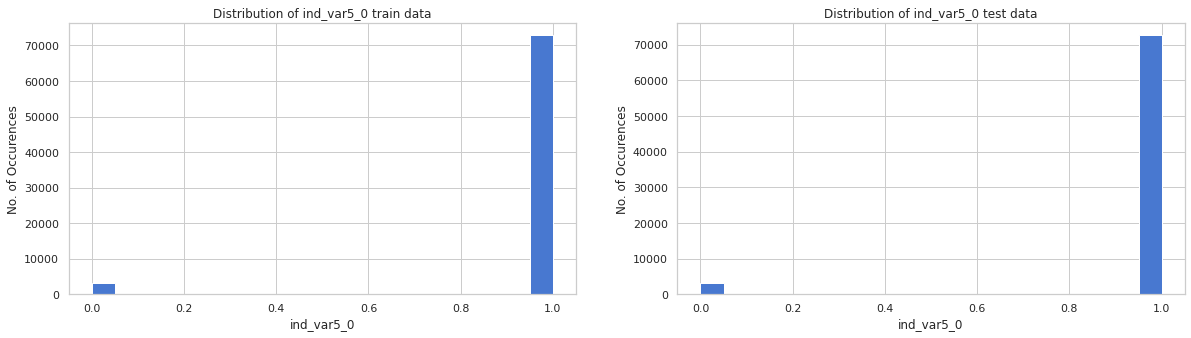

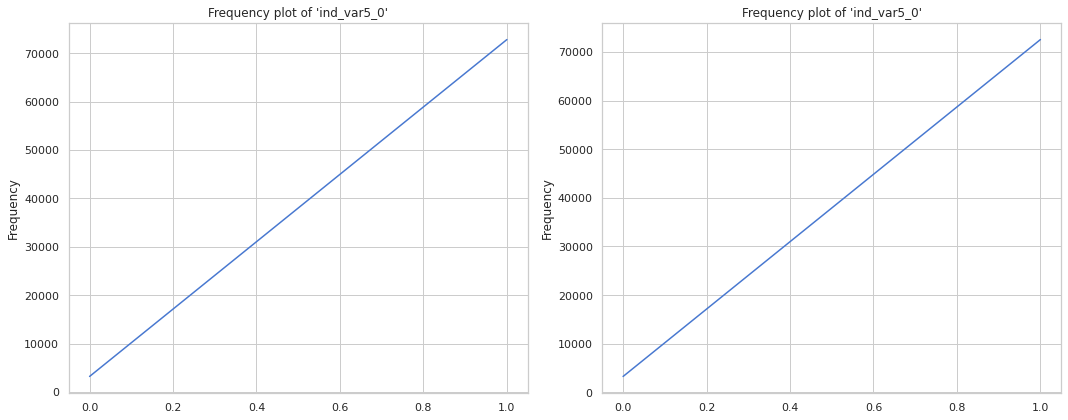

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'ind_var5_0':
Value	 Count%
1    95.80242
0     4.19758
Name: ind_var5_0, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'ind_var5_0':
Value	 Count%
1    95.80242
0     4.19758
Name: ind_var5_0, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'ind_var5_0':
Value	 Count%
1    95.700229
0     4.299771
Name: ind_var5_0, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in test data for 'ind_var5_0':
Value	 Count%
1    95.700229
0     4.299771
Name: ind_var5_0, dtype: float64


In [88]:
#potting frequency plot
histplot_comb(col,train,test)
valuecounts_plot(train=train,test=test,col=col)

There are only 2 values 1 or 0. 1 is having the highest representation.

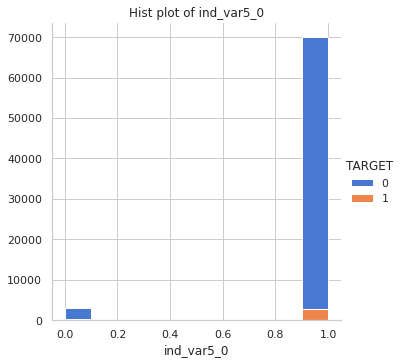

The percent of unsatisfied customers when 'ind_var5_0'==1 is 3.823%
The percent of unsatisfied customers when 'ind_var5_0'==0 is 7.020%


In [89]:
y_col='TARGET'
print('')
sns.FacetGrid(data=train,hue=y_col,height=5).map(plt.hist,col).add_legend()
plt.title("Hist plot of %s"%(col))
plt.show()
for i in train[col].unique():
    print("The percent of unsatisfied customers when '%s'==%i is %.3f%%"%\
      (col,i,train[(train[y_col]==1)&(train[col]==i)][col].shape[0]*100/\
       train[train[col]==i].shape[0]))

# 'ind_var39_0'

In [90]:
col = imp_feat[1]
print("The min and max value in train data for '%s' are %.1f and %.1f"%(col,train[col].min(),train[col].max()))
print("The min and max value in test data for '%s' are %.1f and %.1f"%(col,test[col].min(),test[col].max()))

The min and max value in train data for 'ind_var39_0' are 0.0 and 1.0
The min and max value in test data for 'ind_var39_0' are 0.0 and 1.0


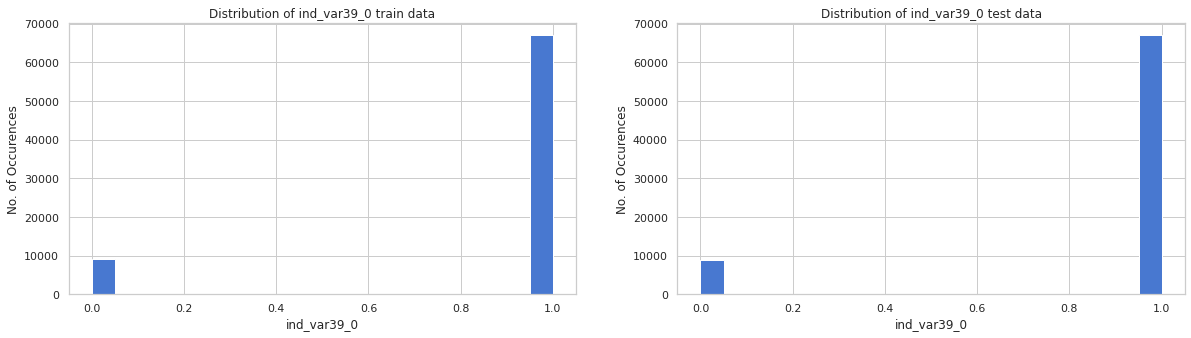

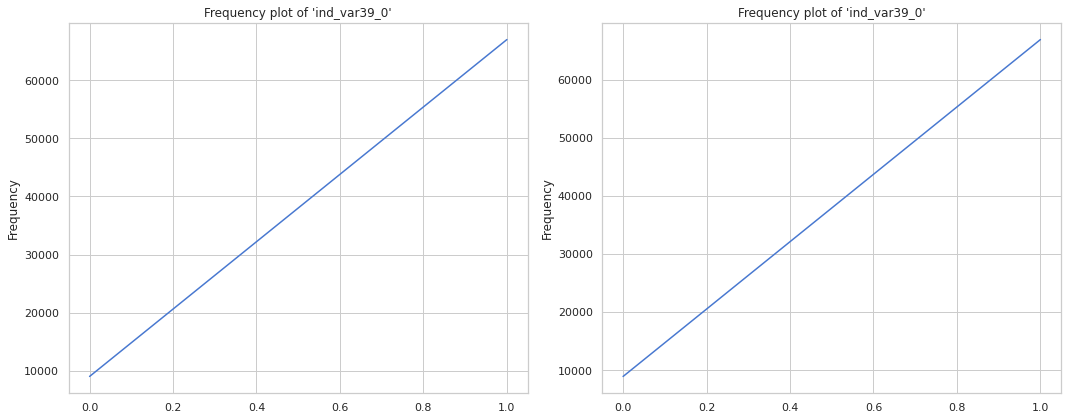

****************************************************************************************************
Percentage value counts(top 5 only) in train data for 'ind_var39_0':
Value	 Count%
1    88.075506
0    11.924494
Name: ind_var39_0, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in train data for 'ind_var39_0':
Value	 Count%
1    88.075506
0    11.924494
Name: ind_var39_0, dtype: float64
****************************************************************************************************
Percentage value counts(top 5 only) in test data for 'ind_var39_0':
Value	 Count%
1    88.254768
0    11.745232
Name: ind_var39_0, dtype: float64
****************************************************************************************************
Percentage value counts(bottom 5 only) in test data for 'ind_var39_0':
Value	 Count%
1    88.254768
0    11.745232
Name: ind_var39_0, dtype: float64


In [91]:
#potting frequency plot
histplot_comb(col,train,test)
valuecounts_plot(train=train,test=test,col=col)


Here also there is only 1 and 0 value. The percentage distribution is similiar in both train and test data.

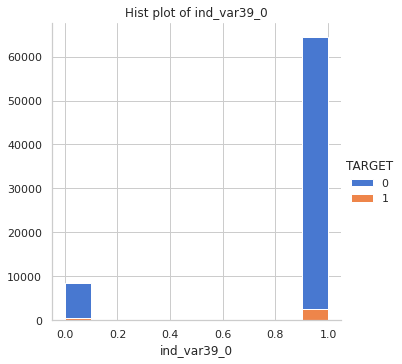

The percent of unsatisfied customers when 'ind_var39_0'==1 is 3.705%
The percent of unsatisfied customers when 'ind_var39_0'==0 is 5.814%


In [92]:
print('')
sns.FacetGrid(data=train,hue=y_col,height=5).map(plt.hist,col).add_legend()
plt.title("Hist plot of %s"%(col))
plt.show()
for i in train[col].unique():
    print("The percent of unsatisfied customers when '%s'==%i is %.3f%%"%\
      (col,i,train[(train[y_col]==1)&(train[col]==i)][col].shape[0]*100/\
       train[train[col]==i].shape[0]))

In [93]:
#analysing every feat of ind
for feat in imp:
    print("%s \t unique-values:%i \t dtype:%s"%(feat,train[feat].nunique(),train[feat].dtype))

ind_var1_0 	 unique-values:2 	 dtype:int64
ind_var5_0 	 unique-values:2 	 dtype:int64
ind_var5 	 unique-values:2 	 dtype:int64
ind_var8_0 	 unique-values:2 	 dtype:int64
ind_var8 	 unique-values:2 	 dtype:int64
ind_var12_0 	 unique-values:2 	 dtype:int64
ind_var12 	 unique-values:2 	 dtype:int64
ind_var13_0 	 unique-values:2 	 dtype:int64
ind_var13_corto_0 	 unique-values:2 	 dtype:int64
ind_var13_corto 	 unique-values:2 	 dtype:int64
ind_var13_largo_0 	 unique-values:2 	 dtype:int64
ind_var13 	 unique-values:2 	 dtype:int64
ind_var14_0 	 unique-values:2 	 dtype:int64
ind_var24_0 	 unique-values:2 	 dtype:int64
ind_var24 	 unique-values:2 	 dtype:int64
ind_var25_cte 	 unique-values:2 	 dtype:int64
ind_var26_cte 	 unique-values:2 	 dtype:int64
ind_var26 	 unique-values:2 	 dtype:int64
ind_var25 	 unique-values:2 	 dtype:int64
ind_var30_0 	 unique-values:2 	 dtype:int64
ind_var30 	 unique-values:2 	 dtype:int64
ind_var37_cte 	 unique-values:2 	 dtype:int64
ind_var37 	 unique-values:2 	 d

We can see that every 'ind' feature only had 2 unique values.

# Strategy for 'ind' features
1. We are leaving it as it is.


# Correlation Matrix

In [94]:
train = pd.read_pickle('pickle_files/train_1.pkl')
test = pd.read_pickle('pickle_files/test_1.pkl')
train.shape,test.shape

((76020, 144), (75818, 143))

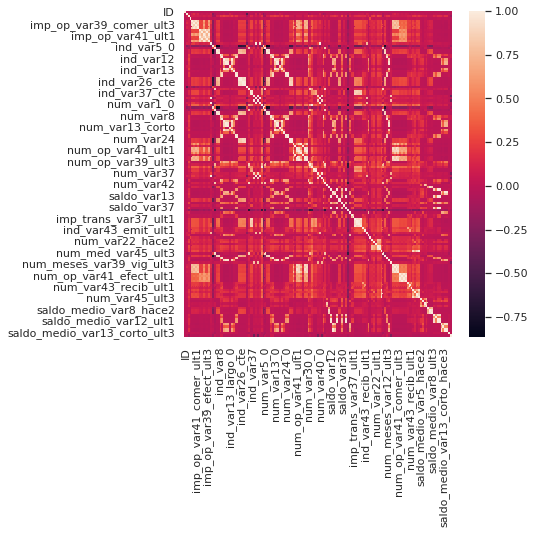

In [95]:
#plotting correlation matrix
corr = train.drop('TARGET',axis=1).corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr)

We can see that there are highly correlated features with one another. We can create a dataset which removes all the highly correlated features keeping one aside to avoid overfitting.

In [96]:
#correlation values between target
corr_df = pd.DataFrame(train.corr()['TARGET']).drop(['ID'])
corr_df.sort_values(by='TARGET',axis=0,ascending=0,inplace=True)
corr_df

,TARGET
TARGET,1.000000
var15,0.111137
var36,0.102919
ind_var8_0,0.046665
num_var8_0,0.046622
...,...
ind_var5,-0.135349
num_var42,-0.135693
num_var30,-0.138289
num_meses_var5_ult3,-0.148253


In [97]:
#finding least correleated variables
t = 10**-4
print(corr_df[abs(corr_df['TARGET'])<=t])
print("There are %i features that are below %.5f correlation value with 'TARGET'."%(corr_df[abs(corr_df['TARGET'])<=t].shape[0],\
                                                                                  t))

                      TARGET
imp_ent_var16_ult1 -0.000017
num_var37_med_ult2 -0.000029
There are 2 features that are below 0.00010 correlation value with 'TARGET'.


We can remove these features.

In [98]:
feat_to_remove = list(corr_df[abs(corr_df['TARGET'])<=t].index)
for df in [train,test]:
    df.drop(feat_to_remove,axis=1,inplace=True)

In [99]:
train.shape,test.shape

((76020, 142), (75818, 141))